In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from itertools import chain

import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [5]:
def get_sents_4day(filename):
    f = open(filename, 'r')
    lines = f.readlines()
    sents = []
    sent = []
    for line in lines:
        if len(line.split()) == 0 or line.strip == '':
            if len(sent) == 0:
                continue
            sents.append(sent)
            sent = []
            continue
        line = line.strip()
        word = line.split()[1]
        pos = line.split()[0]
        sent.append(word + "_" + pos)
    return sents

In [6]:
train_sents = get_sents_4day('pos_train.conll')
test_sents = get_sents_4day('pos_test.conll')

In [15]:
masc_sents = get_sents_4day('masc/written/chapter-10.conll')
len(masc_sents)

287

In [25]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [26]:
import nltk
s = set(nltk.corpus.brown.words())
def word2features(sent, i):
    word_tag = sent[i].split('_')
    word = word_tag[0]
    postag = word_tag[1]
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
#         'postag=' + postag,
#         'postag[:2]=' + postag[:2],
        'word.isuser=%s' % str(word[:1] == '@'),
        'word.ishashtag=%s' % str(word[:1] == '#'),
        'word.isword=%s' % (word.lower() in s),
    ]
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isupper=%s' % word1.isupper(),
#             '-1:postag=' + postag1,
#             '-1:postag[:2]=' + postag1[:2],
            '-1:word.isuser=%s' % str(word[:1] == '@'),
            '-1:word.ishashtag=%s' % str(word[:1] == '#'),
            '-1:word.isword=%s' % (word.lower() in s),
        ])
    else:
        features.append('BOS')
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.extend([
            '+1:word.lower=' + word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isupper=%s' % word1.isupper(),
#             '+1:postag=' + postag1,
#             '+1:postag[:2]=' + postag1[:2],
            '+1:word.isuser=%s' % str(word[:1] == '@'),
            '+1:word.ishashtag=%s' % str(word[:1] == '#'),
            '+1:word.isword=%s' % (word.lower() in s),                
        ])
    else:
        features.append('EOS')
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [word_tag.split('_')[1] for word_tag in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent] 

In [27]:
sent2features(train_sents[0])[0]

['bias',
 'word.lower=antick',
 'word[-3:]=ick',
 'word[-2:]=ck',
 'word.isupper=False',
 'word.istitle=True',
 'word.isdigit=False',
 'word.isuser=False',
 'word.ishashtag=False',
 'word.isword=False',
 'BOS',
 '+1:word.lower=m',
 '+1:word.istitle=True',
 '+1:word.isupper=True',
 '+1:word.isuser=False',
 '+1:word.ishashtag=False',
 '+1:word.isword=False']

In [28]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: user 218 ms, sys: 41.4 ms, total: 259 ms
Wall time: 263 ms


In [29]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 28.5 s, sys: 178 ms, total: 28.7 s
Wall time: 29.1 s


In [30]:
labels = list(crf.classes_)
labels.remove('O')
labels


['NNP',
 'NN',
 ':',
 'CD',
 '(',
 ')',
 'IN',
 'URL',
 'RT',
 'USR',
 'JAMES',
 'HT',
 '.',
 'WRB',
 'PRP',
 'VBP',
 'MD',
 'RB',
 'VB',
 'UH',
 'VBG',
 'JJ',
 ',',
 'CC',
 'PRP$',
 'DT',
 'JJS',
 'NNS',
 'VBZ',
 'RBR',
 'VBN',
 'VBD',
 'SOTO',
 'TO',
 'RP',
 'killer94',
 'EX',
 'POS',
 'WP',
 '',
 'Luvs',
 'WDT',
 'Swagga1',
 'FW',
 'JJR',
 "''",
 'w',
 'liinds',
 'NNPS',
 'Althani',
 'za',
 'nicole2010',
 'Meenie',
 'SYM',
 'Ears',
 'RBS',
 'candelaria',
 'clockwork',
 'Manuchi',
 'wl',
 'am',
 'Panic',
 'Rhiann',
 'ErOtiC',
 'VPP',
 'Score',
 'Kwon',
 '1105',
 'kWC4',
 'Taylor',
 'deadpool',
 'Hadi',
 'Kinghoopa',
 'BertBerry',
 'Messiah113',
 'barbie',
 'Sept15',
 'di',
 's',
 'Patton',
 'aus1980',
 'LS',
 'minion',
 'gee',
 'AsToldByBV',
 '-',
 'walsh',
 'GudBitch',
 'TR',
 'Laura',
 'TD']

In [31]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.84645327833777695

In [32]:
crf.score(X_test, y_test)

0.84522747546833188

In [33]:
item_count = 0
item_total = 0
inst_count = 0
inst_total = 0
for i in range(len(y_test)):
    inst_total += 1
    if (' '.join(y_test[i]) == ' '.join(y_pred[i])):
        inst_count += 1
    for word_test, word_pred in zip(y_test[i], y_pred[i]):
        item_total += 1
        if word_test == word_pred:
            item_count += 1
print ("items: %d out of %d  %0.6f " % (item_count, item_total, float(item_count)/item_total))
print ("instances: %d out of %d  %0.6f " % (inst_count, inst_total, float(inst_count)/inst_total))

items: 1895 out of 2242  0.845227 
instances: 20 out of 118  0.169492 


In [37]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
#     algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(\
    metrics.flat_accuracy_score,\
#     average='weighted',\
#     labels=labels\
)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 18.9min finished


CPU times: user 47.2 s, sys: 3.14 s, total: 50.3 s
Wall time: 19min 27s


In [42]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
# print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.4174062537694039, 'c2': 0.0017341169877228052}
best CV score: 0.828550571449


Dark blue => 0.7856, dark red => 0.8286


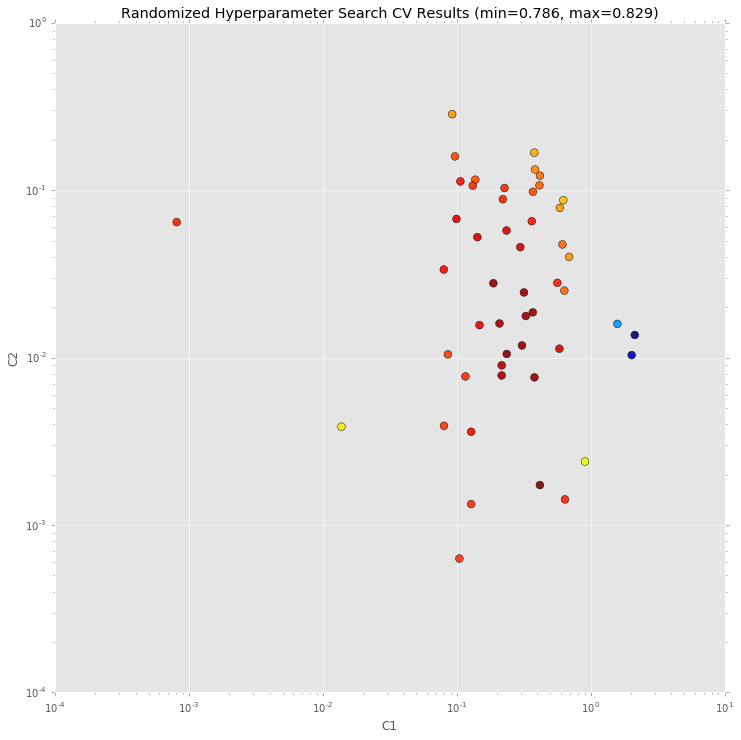

In [39]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

## Let's see per-class results

In [40]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)

sorted_labels = sorted(
    labels,
    key=lambda name: (name)
)

print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))


             precision    recall  f1-score   support

                 1.000     0.750     0.857         4
         ''      1.000     1.000     1.000        10
          (      1.000     1.000     1.000         4
          )      1.000     1.000     1.000         6
          ,      1.000     1.000     1.000        44
          -      0.000     0.000     0.000         0
          .      0.984     0.984     0.984       125
       1105      0.000     0.000     0.000         0
          :      0.940     0.963     0.951        81
    Althani      0.000     0.000     0.000         0
 AsToldByBV      0.000     0.000     0.000         0
  BertBerry      0.000     0.000     0.000         0
         CC      0.932     0.976     0.953        42
         CD      0.829     0.806     0.817        36
         DT      0.972     0.904     0.937       115
         EX      1.000     0.250     0.400         4
       Ears      0.000     0.000     0.000         0
     ErOtiC      0.000     0.000     0.000   

## Accuracy on items and instances

In [41]:
item_count = 0
item_total = 0
inst_count = 0
inst_total = 0
for i in range(len(y_test)):
    inst_total += 1
    if (' '.join(y_test[i]) == ' '.join(y_pred[i])):
        inst_count += 1
    for word_test, word_pred in zip(y_test[i], y_pred[i]):
        item_total += 1
        if word_test == word_pred:
            item_count += 1
print ("items: %d out of %d  %0.6f " % (item_count, item_total, float(item_count)/item_total))
print ("instances: %d out of %d  %0.6f " % (inst_count, inst_total, float(inst_count)/inst_total))

items: 1896 out of 2242  0.845674 
instances: 20 out of 118  0.169492 


## Most likely transitions

In [22]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
wl     -> am      4.857868
MD     -> VB      4.560767
TO     -> VB      3.656991
SYM    -> SYM     3.650117
PRP    -> VBP     3.631396
UH     -> UH      3.471491
WDT    -> VBZ     3.259909
RBR    -> RBR     3.231210
NNP    -> NNPS    3.073804
WP     -> VBZ     3.054705
PRP$   -> NN      2.844130
DT     -> NN      2.834156
NN     -> POS     2.731416
URL    -> HT      2.708884
VBG    -> Patton  2.685840
CD     -> WDT     2.638793
PRP    -> VBD     2.618135
NN     -> WDT     2.614067
UH     -> Rhiann  2.494703
NNS    -> VBP     2.414282

Top unlikely transitions:
POS    -> IN      -1.529310
PRP    -> CD      -1.532860
RB     -> CD      -1.570556
VB     -> VBZ     -1.577139
NNS    -> VBN     -1.595004
VBZ    -> VB      -1.623948
VBZ    -> CC      -1.667563
DT     -> PRP     -1.712807
,      -> :       -1.717021
NNP    -> PRP     -1.736075
VBZ    -> :       -1.775788
VB     -> VBP     -1.778540
VBG    -> UH      -1.799849
VBG    -> VBP     -1.800681
NNP    -> HT     

In [23]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
10.092158 PRP      word.lower=i
9.810632 HT       word.ishashtag=True
9.798638 PRP      word.lower=it
9.561297 TO       word.lower=to
9.204159 DT       word.lower=all
8.312220 WP       word.lower=what
8.238974 PRP      word.lower=its
8.118142 RB       word.lower=n't
8.025167 CC       word.lower=but
8.021120 CC       word.lower=and
7.946586 WRB      word.lower=when
7.898065 DT       word.lower=this
7.673748 PRP      word.lower=you
7.412297 PRP      word.lower=im
7.391946 RB       word.lower=now
7.390340 WRB      word.lower=how
7.281033 RP       word.lower=up
7.278973 PRP$     word.lower=my
7.221896 CC       word.lower=or
7.218389 VBZ      word.lower=is
7.140434 WDT      word.lower=thats
6.961736 IN       word.lower=of
6.954280 IN       word.lower=over
6.951600 PRP      word.lower=we
6.921347 PRP      word.lower=me
6.847075 WRB      word.lower=why
6.798146 DT       word.lower=these
6.767112 WRB      word.lower=where
6.754845 IN       word.lower=after
6.687485 .        word[

## Written
So far we have dealt with twitter dataset, which has very "specific" vocabulary. Now let's see what how our model will work with "written" vocabulary. To do so we got MASC dataset, and checked our model on it

In [45]:
def get_sents_written(filename):
    f = open(filename, 'r')
    lines = f.readlines()
    sents = []
    sent = []
    for line in lines:
        if len(line.split()) == 0 or line.strip == '':
            if len(sent) == 0:
                continue
            sents.append(sent)
            sent = []
            continue
        line = line.strip()
        word = line.split()[1]
        pos = line.split()[3]
        sent.append(word + "_" + pos)
    return sents

In [48]:
written_sents = get_sents_written('masc/written/chapter-10.conll')
train_sents = written_sents[:int(0.6*len(written_sents))]
test_sents = written_sents[int(0.6*len(written_sents)):]

In [51]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: user 144 ms, sys: 58.4 ms, total: 202 ms
Wall time: 216 ms


## Metrics with old model

In [52]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)

sorted_labels = sorted(
    labels,
    key=lambda name: (name)
)

print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))


             precision    recall  f1-score   support

                 1.000     1.000     1.000        12
         ''      0.923     1.000     0.960        60
          (      1.000     1.000     1.000         2
          )      1.000     1.000     1.000         2
          ,      1.000     0.979     0.990       145
          -      0.000     0.000     0.000         0
          .      1.000     0.957     0.978       115
       1105      0.000     0.000     0.000         0
          :      0.458     1.000     0.629        11
    Althani      0.000     0.000     0.000         0
 AsToldByBV      0.000     0.000     0.000         0
  BertBerry      0.000     0.000     0.000         0
         CC      1.000     0.961     0.980        77
         CD      0.754     0.796     0.775        54
         DT      0.908     0.969     0.937       255
         EX      0.000     0.000     0.000         3
       Ears      0.000     0.000     0.000         0
     ErOtiC      0.000     0.000     0.000   

In [53]:
item_count = 0
item_total = 0
inst_count = 0
inst_total = 0
for i in range(len(y_test)):
    inst_total += 1
    if (' '.join(y_test[i]) == ' '.join(y_pred[i])):
        inst_count += 1
    for word_test, word_pred in zip(y_test[i], y_pred[i]):
        item_total += 1
        if word_test == word_pred:
            item_count += 1
print ("items: %d out of %d  %0.6f " % (item_count, item_total, float(item_count)/item_total))
print ("instances: %d out of %d  %0.6f " % (inst_count, inst_total, float(inst_count)/inst_total))

items: 2362 out of 2772  0.852092 
instances: 7 out of 115  0.060870 


## Now let's train new model

In [54]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
#     algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(\
    metrics.flat_accuracy_score,\
#     average='weighted',\
#     labels=labels\
)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.5min finished


CPU times: user 10.3 s, sys: 995 ms, total: 11.3 s
Wall time: 3min 34s


In [55]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
# print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.06127259919333498, 'c2': 0.011144341966718391}
best CV score: 0.884521409812


Dark blue => 0.8298, dark red => 0.8845


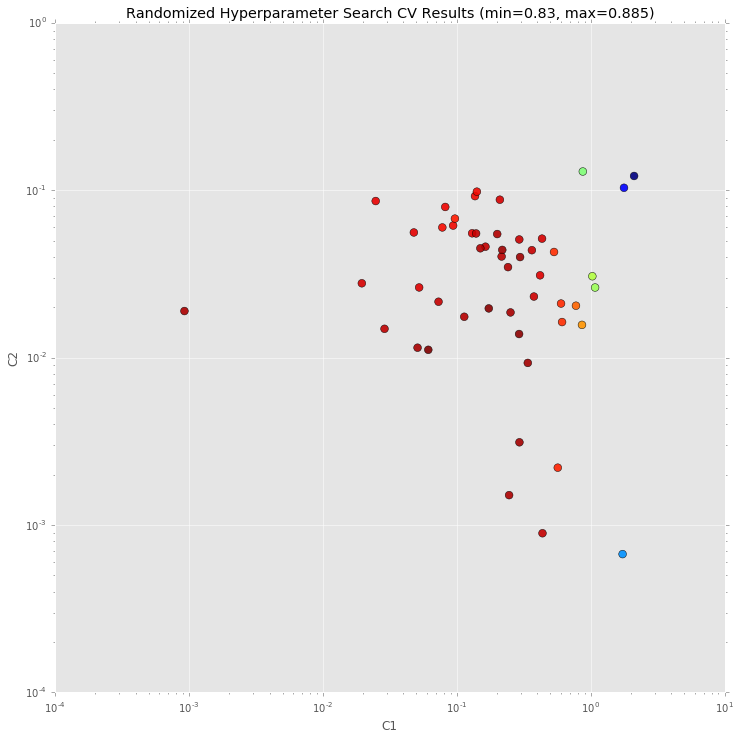

In [56]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [57]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)

sorted_labels = sorted(
    labels,
    key=lambda name: (name)
)

print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))


             precision    recall  f1-score   support

                 1.000     1.000     1.000        12
         ''      0.949     0.933     0.941        60
          (      1.000     1.000     1.000         2
          )      1.000     1.000     1.000         2
          ,      1.000     0.993     0.997       145
          -      0.000     0.000     0.000         0
          .      0.991     0.974     0.982       115
       1105      0.000     0.000     0.000         0
          :      0.556     0.909     0.690        11
    Althani      0.000     0.000     0.000         0
 AsToldByBV      0.000     0.000     0.000         0
  BertBerry      0.000     0.000     0.000         0
         CC      1.000     0.961     0.980        77
         CD      0.927     0.704     0.800        54
         DT      1.000     0.953     0.976       255
         EX      0.000     0.000     0.000         3
       Ears      0.000     0.000     0.000         0
     ErOtiC      0.000     0.000     0.000   

In [58]:
item_count = 0
item_total = 0
inst_count = 0
inst_total = 0
for i in range(len(y_test)):
    inst_total += 1
    if (' '.join(y_test[i]) == ' '.join(y_pred[i])):
        inst_count += 1
    for word_test, word_pred in zip(y_test[i], y_pred[i]):
        item_total += 1
        if word_test == word_pred:
            item_count += 1
print ("items: %d out of %d  %0.6f " % (item_count, item_total, float(item_count)/item_total))
print ("instances: %d out of %d  %0.6f " % (inst_count, inst_total, float(inst_count)/inst_total))

items: 2519 out of 2772  0.908730 
instances: 25 out of 115  0.217391 
